In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import math
import os.path

import keras
import librosa.feature
import sklearn

import pandas
import numpy
from matplotlib import pyplot as plt

import urbansound8k
import preprocess

Using TensorFlow backend.


In [3]:
data = urbansound8k.load_dataset()
data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


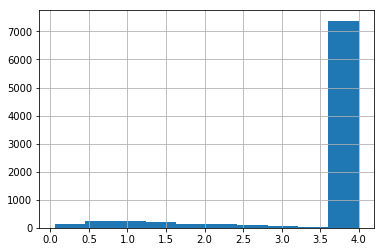

In [4]:
(data.end - data.start).hist()

In [117]:
(data.end-data.start).mode()

0    4.0
dtype: float64

In [14]:
folds, test = urbansound8k.folds(data)
len(folds), folds[0][0].shape, folds[0][1].shape, test.shape

(9, (7022, 8), (873, 8), (837, 8))

In [169]:
# PicakCNN used 950ms, 41 frames for short-frame variant. 50% overlap
def sample_windows(length, frame_samples, window_frames, overlap=0.5):
    """Split @samples into a number of windows of samples
    with length @frame_samples * @window_frames
    """
    ws = frame_samples * window_frames
    start = 0
    while start < (length - (ws * (1-overlap))):
        end = min(start + ws, length)
        yield start, end
        start += (ws * (1-overlap))

frame_samples=512
window_frames=36
fs=16000
w_ms = (frame_samples*window_frames/fs)
print('window size', w_ms)
w = list(sample_windows(int(4.0*fs), frame_samples=frame_samples, window_frames=window_frames))
w[-2][0] - w[-2][1], w[-1][0] - w[-1][1]

window size 1.152


(-18432.0, -17920.0)

cutting 730 samples shorter than 1.0 seconds
37064


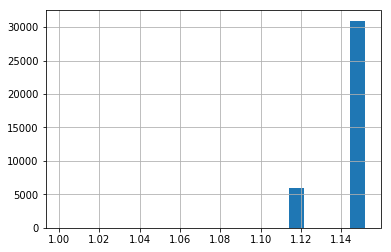

In [211]:
def expand_training_set(samples, frame_samples, window_frames, sample_rate=16000, cut_length=1.0):
    chunks = {
        'slice_file_name': [],
        'fold': [],
        'classID': [],
        'start': [],
        'end': [],
    }
    
    for (index, sample) in samples.iterrows():
        duration = sample.end - sample.start
        length = int(sample_rate * duration)
        for win in sample_windows(length, frame_samples, window_frames):
            start, end = win
            chunks['slice_file_name'].append(sample.slice_file_name)
            chunks['fold'].append(sample.fold)
            # to assume class is same as that of parent sample maybe a bit optimistic
            # not certain that every chunk has content representative of class
            # alternative would be multi-instance learning
            chunks['classID'].append(sample.classID) 
            chunks['start'].append(start/sample_rate)
            chunks['end'].append(end/sample_rate)
            
    df = pandas.DataFrame(chunks)
    
    if cut_length:
        w = (df.end-df.start > cut_length)
        cleaned = df[w]
        print('cutting {} samples shorter than {} seconds'.format(len(df) - len(cleaned), cut_length))
    
    return cleaned

        
df = expand_training_set(folds[0][0], frame_samples=frame_samples, window_frames=window_frames)
print(len(df))
(df.end-df.start).hist(bins=20)  

In [212]:
settings = dict(
    samplerate=16000,
    n_mels=32,
    fmin=0,
    fmax=8000,
    n_fft=512,
    hop_length=256,
)

# TODO: implement data augmentation
def load_sample(sample, window_frames=72):
    n_mels = settings['n_mels']
    sample_rate = settings['samplerate']
    hop_length = settings['hop_length']
    
    # Load precomputed features
    folder = os.path.join('pre', preprocess.settings_id(settings, feature='mels'))
    path = preprocess.feature_path(sample, out_folder=folder)
    mels = numpy.load(path)['arr_0']
    
    # Cut out the relevant part
    start = int(sample.start * (sample_rate / hop_length))
    end = int(sample.end * (sample_rate / hop_length))
    d = (end-start) / sample_rate
    mels = mels[:, start:end]

    # zero-pad window to standard length
    if window_frames is None:
        padded = mels
    else:
        padded = numpy.full((n_mels, window_frames), 0)    
        inp = mels[:, 0:min(window_frames, mels.shape[1])]
        padded[:, 0:inp.shape[1]] = inp
    
    log_mels = librosa.core.power_to_db(padded, top_db=80, ref=numpy.max)
    
    return log_mels
    
load_sample(df.iloc[5]).shape

(32, 73)

In [247]:
import joblib
def gen(X, Y, loader, batchsize=10, n_classes=10, n_jobs=1):
    
    assert len(X) == len(Y), 'X and Y must be equal length'
    assert len(X) % batchsize == 0, 'input length must be divisible by @batchsize'
    
    with joblib.Parallel(n_jobs=n_jobs, prefer='threads') as parallel:
    
        batch_start = 0
        while True:
            if batch_start >= len(X):
                batch_start = 0
            
            def load_data(inp):
                return loader(inp)
                
            bb = X.iloc[batch_start:batch_start+batchsize]
            batch_input = [i for _, i in bb.iterrows()]
            
            # do the heavy part in parallel
            features = parallel(joblib.delayed(load_data)(d) for d in batch_input)
            
            batch_data = []
            batch_labels = []
            for i, data in enumerate(features):
                data = numpy.expand_dims(data, -1)
                y = Y.iloc[batch_start+i]
                y = keras.utils.to_categorical(y, num_classes=n_classes)
                batch_data.append(data)
                batch_labels.append(y)

            batch = (numpy.stack(batch_data), numpy.stack(batch_labels))
            batch_start += batchsize
            yield batch

fold = df
import itertools
g = gen(fold[0:16], fold.classID[0:16], loader=load_sample, batchsize=8)
batches = list(itertools.islice(g, 16))
len(batches), batches[0][0].shape, batches[0][1].shape

(16, (8, 32, 73, 1), (8, 10))

In [ ]:
# import dense
import dilated
model = dilated.build_model(bands=32, frames=73, channels=1)

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

train = expand_training_set(folds[0][0], frame_samples=frame_samples, window_frames=window_frames)
val = expand_training_set(folds[0][1], frame_samples=frame_samples, window_frames=window_frames)

train = train.sample(20000, replace=False)
val = val.sample(2000, replace=False)

batch_size = 50

checkpoint = keras.callbacks.ModelCheckpoint('first.hdf5', monitor='val_acc', mode='max',
                             period=1, verbose=1, save_best_only=True)
callbacks_list = [checkpoint]

train_gen = gen(train, train.classID, loader=load_sample, batchsize=batch_size)
val_gen = gen(val, val.classID, loader=load_sample, batchsize=batch_size)

model.fit_generator(train_gen, validation_data=val_gen,
                    steps_per_epoch=math.ceil(len(train)/batch_size),
                    validation_steps=math.ceil(len(val)/batch_size),
                    callbacks=callbacks_list,
                    epochs=10, verbose=1)

cutting 730 samples shorter than 1.0 seconds
cutting 74 samples shorter than 1.0 seconds
Epoch 1/10
400/400 [==============================] - 2530s 6s/step - loss: 1.8873 - acc: 0.3179 - val_loss: 1.4412 - val_acc: 0.5152

Epoch 00001: saving model to first
Epoch 2/10
400/400 [==============================] - 2292s 6s/step - loss: 1.5540 - acc: 0.4491 - val_loss: 1.2818 - val_acc: 0.6235

Epoch 00002: saving model to first
Epoch 3/10
400/400 [==============================] - 2911s 7s/step - loss: 1.3947 - acc: 0.5131 - val_loss: 1.2589 - val_acc: 0.5938

Epoch 00003: saving model to first
Epoch 4/10
400/400 [==============================] - 2238s 6s/step - loss: 1.2803 - acc: 0.5562 - val_loss: 1.1814 - val_acc: 0.6558

Epoch 00004: saving model to first
Epoch 5/10
400/400 [==============================] - 2351s 6s/step - loss: 1.1925 - acc: 0.5903 - val_loss: 1.1229 - val_acc: 0.6903

Epoch 00005: saving model to first
Epoch 6/10
 89/400 [=====>........................] - ETA: 24

In [240]:
model.save('first.hdf5')